

https://github.com/tensorflow/swift/blob/master/docs/site/tutorials/model_training_walkthrough.ipynb

In [1]:
%include "data.swift"
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let path = Python.import("os.path")
let urllib = Python.import("urllib.request")
let helperFiles = ["TutorialDatasetCSVAPI.swift"]
let helperFileBaseURL = "https://raw.githubusercontent.com/tensorflow/swift/master/docs/site/tutorials/"
for helperFile in helperFiles {
    if !Bool(path.isfile(helperFile))! {
        print("Downloading \(helperFile)")
        urllib.urlretrieve(helperFileBaseURL + helperFile, filename: helperFile)
    } else {
        print("Not downloading \(helperFile): already exists")
    }
}

Not downloading TutorialDatasetCSVAPI.swift: already exists


# Download Training Data

In [2]:
let urllib = Python.import("urllib.request")
let downloadResult = urllib.urlretrieve(
    "http://download.tensorflow.org/data/iris_training.csv",
    "iris_training.csv")
let trainDataFilename = String(downloadResult[0])!
trainDataFilename

"iris_training.csv"


In [3]:
let f = Python.open(trainDataFilename)
for _ in 0..<5 {
    print(Python.next(f).strip())
}
f.close()

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


None


In [4]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Features: ["sepal_length", "sepal_width", "petal_length", "petal_width"]
Label: species


In [5]:
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

# Create Dataset

In [6]:
let batchSize = Int64(32)

/// A batch of examples from the iris dataset.
struct IrisBatch {
    /// [batchSize, featureCount] tensor of features.
    let features: Tensor<Float>

    /// [batchSize] tensor of labels.
    let labels: Tensor<Int32>
}

%include "TutorialDatasetCSVAPI.swift"

let trainDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: trainDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

In [7]:
let firstTrainExamples = trainDataset.first!
let firstTrainFeatures = firstTrainExamples.features
let firstTrainLabels = firstTrainExamples.labels
print("First batch of features: \(firstTrainFeatures)")
print("First batch of labels: \(firstTrainLabels)")

First batch of features: [[6.4, 2.8, 5.6, 2.2], [5.0, 2.3, 3.3, 1.0], [4.9, 2.5, 4.5, 1.7], [4.9, 3.1, 1.5, 0.1], [5.7, 3.8, 1.7, 0.3], [4.4, 3.2, 1.3, 0.2], [5.4, 3.4, 1.5, 0.4], [6.9, 3.1, 5.1, 2.3], [6.7, 3.1, 4.4, 1.4], [5.1, 3.7, 1.5, 0.4], [5.2, 2.7, 3.9, 1.4], [6.9, 3.1, 4.9, 1.5], [5.8, 4.0, 1.2, 0.2], [5.4, 3.9, 1.7, 0.4], [7.7, 3.8, 6.7, 2.2], [6.3, 3.3, 4.7, 1.6], [6.8, 3.2, 5.9, 2.3], [7.6, 3.0, 6.6, 2.1], [6.4, 3.2, 5.3, 2.3], [5.7, 4.4, 1.5, 0.4], [6.7, 3.3, 5.7, 2.1], [6.4, 2.8, 5.6, 2.1], [5.4, 3.9, 1.3, 0.4], [6.1, 2.6, 5.6, 1.4], [7.2, 3.0, 5.8, 1.6], [5.2, 3.5, 1.5, 0.2], [5.8, 2.6, 4.0, 1.2], [5.9, 3.0, 5.1, 1.8], [5.4, 3.0, 4.5, 1.5], [6.7, 3.0, 5.0, 1.7], [6.3, 2.3, 4.4, 1.3], [5.1, 2.5, 3.0, 1.1]]
First batch of labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


In [8]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()

In [9]:
let petalLengths = firstTrainFeaturesTransposed[2].scalars

In [10]:
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

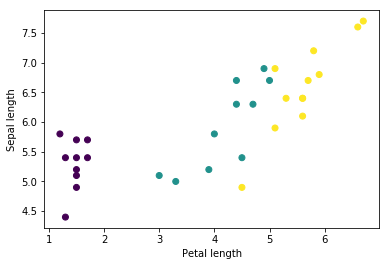

None


In [11]:
plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

# Create Model

In [12]:
import TensorFlow

let hiddenSize: Int = 10
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        return input.sequenced(in: context, through: layer1, layer2, layer3)
    }
}

var model = IrisModel()

In [13]:
// A `Context` tells the model what it's being used for. The `IrisModel` does
// not actually use the `Context`, but the `Layer` API requires `Context` so
// that it can support more complex models that depend on context. Here, we
// construct an "inference" context because we're using the model to infer
// labels.
let inferenceContext = Context(learningPhase: .inference)

// Apply the model to a batch of features.
let firstTrainPredictions = model.applied(to: firstTrainFeatures, in: inferenceContext)
firstTrainPredictions[0..<5]

[[-0.9421841, 0.20991462, -2.8552072], [-0.5084336, 0.013061881, -2.0356379], [-0.8023455, 0.1578716, -2.2996225], [-0.11014998, -0.30850458, -1.8981066], [-0.14839333, -0.33029073, -2.245045]]


In [14]:
softmax(firstTrainPredictions[0..<5])

[[0.23188615, 0.73387975, 0.034234136], [0.3446271, 0.5805399, 0.074832976], [0.26068807, 0.680986, 0.05832597], [0.50317484, 0.41264313, 0.084181994], [0.5111027, 0.4260996, 0.06279773]]


In [15]:
print("Prediction: \(firstTrainPredictions.argmax(squeezingAxis: 1))")
print("    Labels: \(firstTrainLabels)")

Prediction: [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
    Labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


# Loss test for untrained model

In [16]:
let trainingContext = Context(learningPhase: .training)

let untrainedLogits = model.applied(to: firstTrainFeatures, in: trainingContext)
let untrainedLoss = softmaxCrossEntropy(logits: untrainedLogits, labels: firstTrainLabels)
print("Loss test: \(untrainedLoss)")

Loss test: 1.6318698


# Train One Step

In [17]:
let optimizer = SGD<IrisModel, Float>(learningRate: 0.01)

In [18]:
let (loss, grads) = model.valueWithGradient { model -> Tensor<Float> in
    let logits = model.applied(to: firstTrainFeatures, in: trainingContext)
    return softmaxCrossEntropy(logits: logits, labels: firstTrainLabels)
}
print("Current loss: \(loss)")

Current loss: 1.6318698


In [19]:
optimizer.update(&model.allDifferentiableVariables, along: grads)

In [20]:
let logitsAfterOneStep = model.applied(to: firstTrainFeatures, in: trainingContext)
let lossAfterOneStep = softmaxCrossEntropy(logits: logitsAfterOneStep, labels: firstTrainLabels)
print("Next loss: \(lossAfterOneStep)")

Next loss: 1.5084047


# Train 500 Epochs

In [21]:
let epochCount = 500
var trainAccuracyResults: [Float] = []
var trainLossResults: [Float] = []

In [22]:
func accuracy(predictions: Tensor<Int32>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions .== truths).mean().scalarized()
}

for epoch in 1...epochCount {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for batch in trainDataset {
        let (loss, grad) = model.valueWithGradient { (model: IrisModel) -> Tensor<Float> in
            let logits = model.applied(to: batch.features, in: trainingContext)
            return softmaxCrossEntropy(logits: logits, labels: batch.labels)
        }
        optimizer.update(&model.allDifferentiableVariables, along: grad)
        
        let logits = model.applied(to: batch.features, in: trainingContext)
        epochAccuracy += accuracy(predictions: logits.argmax(squeezingAxis: 1), truths: batch.labels)
        epochLoss += loss.scalarized()
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    if epoch % 50 == 0 {
        print("Epoch \(epoch): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
    }
}

Epoch 50: Loss: 0.43071976, Accuracy: 0.7916667
Epoch 100: Loss: 0.3095292, Accuracy: 0.9661458
Epoch 150: Loss: 0.21911182, Accuracy: 0.984375
Epoch 200: Loss: 0.16477627, Accuracy: 0.9921875
Epoch 250: Loss: 0.13504912, Accuracy: 0.9921875
Epoch 300: Loss: 0.11774152, Accuracy: 0.9921875
Epoch 350: Loss: 0.10684325, Accuracy: 0.9921875
Epoch 400: Loss: 0.09953078, Accuracy: 0.9921875
Epoch 450: Loss: 0.094296195, Accuracy: 0.9921875
Epoch 500: Loss: 0.09040431, Accuracy: 0.9921875


# Plot Accuracy and Loss over 500 Epochs

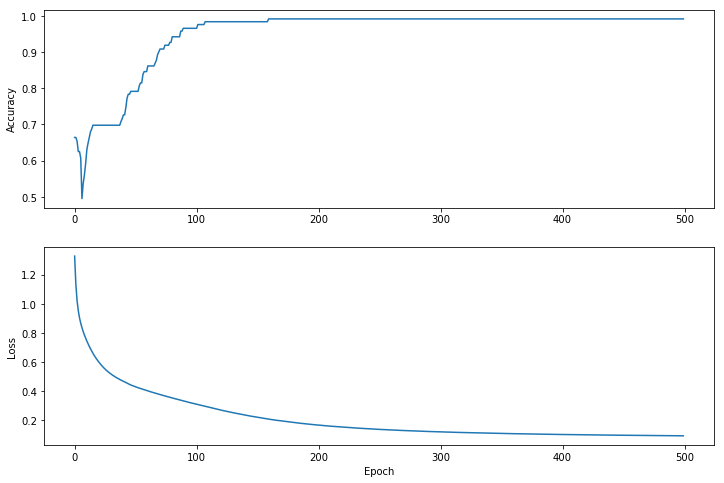

None


In [23]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Accuracy")
accuracyAxes.plot(trainAccuracyResults)

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Loss")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(trainLossResults)

plt.show()

# Measure Model Accuracy on Test Dataset

In [24]:
let urllib = Python.import("urllib.request")
let downloadResult = urllib.urlretrieve(
    "http://download.tensorflow.org/data/iris_test.csv",
    "iris_test.csv")
let testDataFilename = String(downloadResult[0])!
testDataFilename

"iris_test.csv"


In [25]:
let testDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: testDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

In [26]:
// NOTE: With `batchSize = 32` and 30 examples in the test dataset, only one batch will run in the loop.
for testBatch in testDataset {
    let logits = model.applied(to: testBatch.features, in: inferenceContext)
    let predictions = logits.argmax(squeezingAxis: 1)
    print("Test batch accuracy: \(accuracy(predictions: predictions, truths: testBatch.labels))")
}

Test batch accuracy: 0.96666664


In [27]:
let firstTestBatch = testDataset.first!
let firstTestBatchLogits = model.applied(to: firstTestBatch.features, in: inferenceContext)
let firstTestBatchPredictions = firstTestBatchLogits.argmax(squeezingAxis: 1)

print(firstTestBatchPredictions)
print(firstTestBatch.labels)

[1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]
[1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]


# Predict on Unlabeled Dataset
* 0: Iris setosa
* 1: Iris versicolor
* 2: Iris virginica


In [28]:
let unlabeledDataset: Tensor<Float> =
    [[5.1, 3.3, 1.7, 0.5],
     [5.9, 3.0, 4.2, 1.5],
     [6.9, 3.1, 5.4, 2.1]]

let unlabeledDatasetPredictions = model.applied(to: unlabeledDataset, in: inferenceContext)

for i in 0..<unlabeledDatasetPredictions.shape[0] {
    let logits = unlabeledDatasetPredictions[i]
    let classIdx = logits.argmax().scalar!
    print("Example \(i) prediction: \(classNames[Int(classIdx)]) (\(softmax(logits)))")
}

Example 0 prediction: Iris setosa ([0.9946543, 0.0053456994, 1.1668187e-08])
Example 1 prediction: Iris versicolor ([0.0016232324, 0.99012685, 0.008249931])
Example 2 prediction: Iris virginica ([0.00011415659, 0.1907772, 0.8091087])
